# Машинное обучение, ММП ВМК МГУ

## Практическое задание 4. Разложение ошибки на смещение и разброс. Градиентный бустинг ~~своими руками~~

### Общая информация

Дата выдачи: 09.12.2019

Мягкий дедлайн: 23:59MSK 22.12.2019

Жесткий дедлайн: 23:59MSK 29.12.2019

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-06-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

В этом задании вам предстоит воспользоваться возможностями bootstraping для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston. 
Также в задании вам будет предложено пообучать готовые модели градиентного бустинга и CatBoost.

## Часть 1. Bias-Variance Decomposition

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
from sklearn.datasets import load_boston

In [126]:
boston = load_boston()

In [127]:
X = boston["data"]
y = boston["target"]

In [128]:
X.shape, y.shape

((506, 13), (506,))

In [3]:
import warnings
warnings.filterwarnings('ignore')

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) = 
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] = 
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [7]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

33.357036033750106

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка. 

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$. 

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$. 

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__Задание 1. (3 балла)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [172]:
def compute_biase_variance(regressor, X, y, num_runs=1000):
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set ob objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)
    
    :returns: bias (float), variance (float), error (float) 
    each value is computed using bootstrap
    """
    preds = np.empty((num_runs, X.shape[0]))
    preds.fill(np.nan)
    
    all_idx = set(np.arange(X.shape[0]))
    for i in range(num_runs):
        idx = np.random.randint(0, X.shape[0], X.shape[0])
        idx_t = list(all_idx.difference(idx))
        a = regressor.fit(X[idx], y[idx])
        pred = regressor.predict(X[idx_t])
        preds[i, idx_t] = pred
        
    
    #смещение
    b = np.mean((np.nanmean(preds, axis = 0) - y)**2)
    #разброс
    v = np.mean(np.nanmean((preds - np.nanmean(preds, axis = 0))**2, axis = 0))
    #ошибка
    l = np.nanmean((preds - y)**2)
    
    return b, v, l, b+v-l
    
    ### your code here ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

**Задание 2. (1 балл)**

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.


In [4]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [177]:
b, v, l, diff = compute_biase_variance(DecisionTreeRegressor(), X, y)
print("bias = ", b, ", variance = ", v, 'L = ', l,', difference = ', diff)

bias =  10.294122240805095 , variance =  13.0149424219365 L =  23.387853344874493 , difference =  -0.07878868213289891


In [178]:
b, v, l, diff = compute_biase_variance(LinearRegression(), X, y)
print("bias = ", b, ", variance = ", v, 'L = ', l,', difference = ', diff)

bias =  23.745499732562234 , variance =  0.9350169396342697 L =  24.619825579620887 , difference =  0.06069109257561678


In [179]:
b, v, l, diff = compute_biase_variance(RandomForestRegressor(), X, y)
print("bias = ", b, ", variance = ", v, 'L = ', l,', difference = ', diff)

bias =  10.691715990898091 , variance =  3.42050607111665 L =  14.157095421336985 , difference =  -0.0448733593222439


Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на семинарах (с комментарием)?



Дерево решений: небольшое смещение, большой разброс, суммарная ошибка большая

Линейная регрессия: большое смещение, маленький разброс, суммарная ошибка большая

Случайный лес: небольшое смещение, средний разброс, суммарная ошибка небольшая


Небольшое смещение означает, что в среднем модель выдает правильный ответ, а небольшой разброс - что прогнозы модели мало отклоняются от среднего значения. Случайный лес обладет меньшей дисперсий по сравнению с деревом решений, так как усреднение по прогнозов непохожих деревьев, обученных на разных бутстраповских выборках, позволяет скорректировать и уменьшить дисперсии.

Для случайного леса в теории дисперсия должна уменьшиться в n_estimators = 100 раз относительно одного решающего дерева, однако в эксперименте уменьшилась лишь в 3. Это может быть связано с особенностями выборки и ее небольшим размером, деревья леса могут получаться похожими, зависимыми.




### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__Задание 3. (2 балла)__

Реализуйте фукнцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [5]:
import matplotlib.pyplot as plt

In [133]:
def plot_predictions(regressor, X, y, num_runs=100, num_test_objects=10, title=""):
    """
    plot graphics described above
    """
    idx = np.arange(X.shape[0])
    np.random.shuffle(idx)
    idx_test = idx[:num_test_objects]
    
    X_test = X[idx_test]
    y_test = y[idx_test]

    idx_train = idx[num_test_objects:]
    
    X_train = X[idx_train]
    y_train = y[idx_train]
    
    preds = np.zeros((num_runs, X_test.shape[0]))
    all_idx = set(np.arange(X_train.shape[0]))
    for i in range(num_runs):
        idx = np.random.randint(0, X_train.shape[0], X_train.shape[0])
        idx_t = list(all_idx.difference(idx))
        a = regressor.fit(X_train[idx], y_train[idx])
        pred = regressor.predict(X_test)
        preds[i] = pred
    
    
    fig = plt.figure(figsize=(6, 4))
    ax = plt.subplot(111)
    ax.scatter(np.arange(num_test_objects), y_test, c='black')

    for i in range(num_runs):
        ax.scatter(np.arange(num_test_objects), preds[i], c='r')
    ax.scatter(np.arange(num_test_objects), y_test, c='black')

    ax.legend(['истинный ответ', 'предсказанный ответ'])
    ax.set_ylabel('прогноз')
    ax.set_xlabel('номер объекта')
    ax.set_title(title)
    ax.grid()


    ### your code here ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

In [148]:
def plot_predictions_str(regressor1,regressor2, regressor3, X, y, num_runs=100, num_test_objects=10, 
                         title1 ="", title2="", title3=""):
    """
    plot graphics described above
    """
    idx = np.arange(X.shape[0])
    np.random.shuffle(idx)
    idx_test = idx[:num_test_objects]
    
    X_test = X[idx_test]
    y_test = y[idx_test]

    idx_train = idx[num_test_objects:]
    
    X_train = X[idx_train]
    y_train = y[idx_train]
    
    preds1 = np.zeros((num_runs, X_test.shape[0]))
    preds2 = np.zeros((num_runs, X_test.shape[0]))
    preds3 = np.zeros((num_runs, X_test.shape[0]))

    all_idx = set(np.arange(X_train.shape[0]))
    for i in range(num_runs):
        idx = np.random.randint(0, X_train.shape[0], X_train.shape[0])
        idx_t = list(all_idx.difference(idx))
        a = regressor1.fit(X_train[idx], y_train[idx])
        pred = regressor1.predict(X_test)
        preds1[i] = pred
        
        a = regressor2.fit(X_train[idx], y_train[idx])
        pred = regressor2.predict(X_test)
        preds2[i] = pred
        
        a = regressor3.fit(X_train[idx], y_train[idx])
        pred = regressor3.predict(X_test)
        preds3[i] = pred
    
       
    f, (ax1, ax2, ax3) = plt.subplots(ncols = 3, nrows =1, sharey = 'all', figsize=(15, 4)) 
    
    ax1.scatter(np.arange(num_test_objects), y_test, c='black')
    ax2.scatter(np.arange(num_test_objects), y_test, c='black')
    ax3.scatter(np.arange(num_test_objects), y_test, c='black')


    for i in range(num_runs):
        ax1.scatter(np.arange(num_test_objects), preds1[i], c='r')
        ax2.scatter(np.arange(num_test_objects), preds2[i], c='r')
        ax3.scatter(np.arange(num_test_objects), preds3[i], c='r')
    ax1.scatter(np.arange(num_test_objects), y_test, c='black')
    ax2.scatter(np.arange(num_test_objects), y_test, c='black')
    ax3.scatter(np.arange(num_test_objects), y_test, c='black')
    
    ax1.legend(['истинный ответ', 'предсказанный ответ'])
    ax1.set_ylabel('прогноз')
    ax1.set_xlabel('номер объекта')
    ax1.set_title(title1)
    ax1.grid()

        
    ax2.set_xlabel('номер объекта')
    ax2.set_title(title2)
    ax2.grid()
        
    ax3.set_xlabel('номер объекта')
    ax3.set_title(title3)
    ax3.grid()

    ### your code here ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

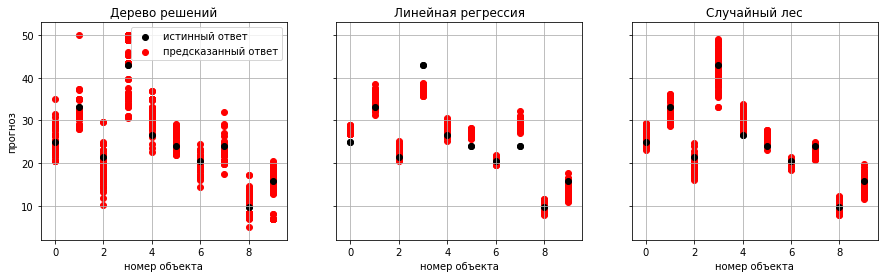

In [149]:
 plot_predictions_str(DecisionTreeRegressor(), LinearRegression(),RandomForestRegressor(),X, y,100, 10, "Дерево решений", "Линейная регрессия", "Случайный лес")

Дерево решений: небольшое смещение, большой разброс


Линейная регрессия: большое смещение, маленький разброс


Случайный лес: небольшое смещение, средний разброс


Визуализация совпадает с ожидаемыми значениями смещения и дисперсии, посчитанными выше.

### Часть 2. Градиентный бустинг

**Задание 4 (1 балл)**

Мы будем использовать данные из [соревнования](https://www.kaggle.com/t/b710e05dc0bd424995ca94da5b639869). 
* Загрузите таблицу application_train.csv;
* Запишите в Y столбец с целевой переменной (TARGET);
* Удалите ненужные столбцы (для этого воспользуйтесь описанием);
* Определите тип столбцов и заполните пропуски - стратегия произвольная;
* Разбейте выборку в соотношении 70:30 с random_state=0.

Так как в данных имеется значительный дисбаланс классов, в качестве метрики качества везде будем использовать площадь под precision-recall кривой (AUC-PR).

Для категориальных признаков сделан LabelEncoding, пропусти в вещественных параметрах заполнены средним, в целочисленных - самым частым значением.

In [32]:
from  sklearn.preprocessing import LabelEncoder

In [33]:
md = LabelEncoder()

In [34]:
data = pd.read_csv("application_train.csv")

In [35]:
data.shape

(215257, 122)

In [36]:
cat = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_CONTRACT_TYPE', 'NAME_TYPE_SUITE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_INCOME_TYPE','NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 
       'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']

In [37]:
for c in cat:
    data[c] = data[c].apply(lambda s:str(s))
    data[c] = md.fit_transform(data[c])

In [38]:
y = data['TARGET']

In [39]:
data.drop(['SK_ID_CURR', 'TARGET', 'FONDKAPREMONT_MODE', 'EMERGENCYSTATE_MODE', 'FLAG_CONT_MOBILE',
          'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION'], axis = 1, inplace = True)
#Целочисленные признаки удалены, если по описанию они принимают почти для всех объектов одинаковые значения, или много пропусков

In [40]:
for cols in data:
    if data[cols].isna().sum() / data[cols].shape[0] * 100 >  60:
        data.drop(cols, axis = 1, inplace = True)
        print(cols)
        
#дополниетльно удалены все признаки, в которых больше 60% пропусков

OWN_CAR_AGE
YEARS_BUILD_AVG
COMMONAREA_AVG
FLOORSMIN_AVG
LIVINGAPARTMENTS_AVG
NONLIVINGAPARTMENTS_AVG
YEARS_BUILD_MODE
COMMONAREA_MODE
FLOORSMIN_MODE
LIVINGAPARTMENTS_MODE
NONLIVINGAPARTMENTS_MODE
YEARS_BUILD_MEDI
COMMONAREA_MEDI
FLOORSMIN_MEDI
LIVINGAPARTMENTS_MEDI
NONLIVINGAPARTMENTS_MEDI


In [41]:
for cols in data:
    if data[cols].dtype  == 'int64':
        data[cols].fillna(data[cols].value_counts().index[0], inplace = True) #самое популярнное знач
    else:
        data[cols].fillna(data[cols].mean(), inplace = True) #среднее
        
#заполнили пропуски

In [42]:
from sklearn.model_selection import train_test_split

In [43]:
data_float = data.copy()

In [46]:
data_float.shape

(215257, 49)

In [47]:
X_train, X_test, y_train, y_test= train_test_split(data_float, y, test_size = 0.3, random_state = 0)

In [48]:
X_train.shape, y_train.shape

((150679, 49), (150679,))

**Задание 5 (1 балл)**

Обучите реализации градиентного бустинга LightGBM и Catboost на вещественных признаках без подбора параметров. **Почему получилась заметная разница в качестве?**

В этом и последующих экспериментах необходимо измерять время обучения моделей.

In [49]:
! pip install lightgbm
! pip install --upgrade catboost==0.19.1

Requirement already up-to-date: catboost==0.19.1 in c:\users\пользователь\appdata\roaming\python\python36\site-packages (0.19.1)


In [23]:
from sklearn.metrics import precision_recall_curve, auc
from time import time

def time_auc_score(clf, X_train, y_train, X_test, y_test):
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    print("time = ", end - start)
    pred = clf.predict(X_test)
    precision, recall, _ = precision_recall_curve(y_test, pred)
    return (auc(recall, precision))

In [24]:
from catboost import CatBoostClassifier 
clf = CatBoostClassifier(verbose = 0)
time_auc_score(clf, X_train, y_train, X_test, y_test)

time =  73.23544549942017


0.33951783824327997

In [25]:
from lightgbm import LGBMClassifier
from time import time
clf = LGBMClassifier()
time_auc_score(clf, X_train, y_train, X_test, y_test)

time =  5.819442987442017


0.37637560010155735

Заметной разницы в качестве не получилось. Без подбора параметров точность классификации моделями хуже, чем у случайного классификатора. Разница во времени работы обусловлена реализацией алгоритмов: LGBM сильно оптимизирует вычислительные затраты через сокращение количества объектов и признаков выборки.

**Your answer here:**

__Задание 6. (2 балла)__

Подберите оптимальные с точки зрения метрики качества параметры алгоритмов, изменяя:

* глубину деревьев;
* количество деревьев;
* темп обучения;
* оптимизируемый функционал.

Масштаб значений предлагается посмотреть в [семинаре](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/seminars/sem10-gbm.ipynb) про библиотеки.

**Проанализируйте соотношения глубины и количества деревьев в зависимости от алгоритма.** 

**Если на перебор гиперпараметров уходит много времени, то переберите значениях каких-нибудь 1-2 гиперпараметров, а не всех предложенных 4**

In [8]:
from sklearn.model_selection import GridSearchCV, KFold

In [38]:
n_trees = [1, 5, 10, 100, 200, 300, 400, 500, 600, 700]
depth = list(range(1, 12, 2))
depth.append(None)
learning_rate = np.logspace(-5, 0, 10)
learning_rate = list(learning_rate)
loss = ['Logloss', 'CrossEntropy']

In [59]:
from sklearn.metrics import fbeta_score, make_scorer

def my_custom_loss_func(y_true, y_pred):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    return auc(recall, precision)

score = make_scorer(my_custom_loss_func, greater_is_better=True)

In [74]:
def search_params(clf, param, X_train, y_train):
    kf = KFold(n_splits=5)
    cv = kf.split(X_train)
    search = GridSearchCV(clf, param, cv = cv, scoring = score)
    search.fit(X_train, y_train)  
    print(search.best_params_)
    return search.best_params_

In [66]:
param = {'n_estimators':n_trees}
c = search_params(CatBoostClassifier(verbose = 0), param, X_train, y_train)
time_auc_score(CatBoostClassifier(verbose = 0, n_estimators = c['n_estimators']), X_train, y_train, X_test, y_test)

{'n_estimators': 1}
time =  1.0432116985321045


0.5398897457338413

In [76]:
param = {'max_depth':depth}

c = search_params(CatBoostClassifier(verbose = 0, n_estimators = 1), param, X_train, y_train)
time_auc_score(CatBoostClassifier(verbose = 0, n_estimators = 1, max_depth = c['max_depth']), X_train, y_train, X_test, y_test)

{'max_depth': 1}
time =  0.6642646789550781


0.5398897457338413

In [77]:
param = {'loss_function':loss}

c = search_params(CatBoostClassifier(verbose = 0, n_estimators = 1, max_depth = 1), param, X_train, y_train)
time_auc_score(CatBoostClassifier(verbose = 0, n_estimators = 1, max_depth = 1, loss_function = c['loss_function']),
               X_train, y_train, X_test, y_test)

{'loss_function': 'Logloss'}
time =  0.5383603572845459


0.5398897457338413

In [79]:
param = {'learning_rate':learning_rate}
c = search_params(CatBoostClassifier(verbose = 0, n_estimators = 1, max_depth = 1), param, X_train, y_train)
time_auc_score(CatBoostClassifier(verbose = 0, n_estimators = 1, max_depth = 1, learning_rate = c['learning_rate']),
               X_train, y_train, X_test, y_test)

{'learning_rate': 1e-05}
time =  0.6779425144195557


0.5398897457338413

Оптимальные гиперпараметры для CatBoost: learning rate = $10^{-5}$, n_estimators = 1, max_depth = 1, loss_function = LogLoss.
С ними AUC = 0.54.

In [80]:
param = {'n_estimators':n_trees}
c = search_params(LGBMClassifier(verbose = 0), param, X_train, y_train)
time_auc_score(LGBMClassifier(verbose = 0, n_estimators = c['n_estimators']), X_train, y_train, X_test, y_test)

{'n_estimators': 1}
time =  1.1860969066619873


0.5398897457338413

In [81]:
param = {'max_depth':depth}

c = search_params(LGBMClassifier(verbose = 0, n_estimators = 1), param, X_train, y_train)
time_auc_score(LGBMClassifier(verbose = 0, n_estimators = 1, max_depth = c['max_depth']), X_train, y_train, X_test, y_test)

{'max_depth': 1}
time =  1.1226377487182617


0.5398897457338413

In [82]:
param = {'loss_function':loss}

c = search_params(LGBMClassifier(verbose = 0, n_estimators = 1, max_depth = 1), param, X_train, y_train)
time_auc_score(LGBMClassifier(verbose = 0, n_estimators = 1, max_depth = 1, loss_function = c['loss_function']),
               X_train, y_train, X_test, y_test)

{'loss_function': 'Logloss'}
time =  1.0869359970092773


0.5398897457338413

In [83]:
param = {'learning_rate':learning_rate}
c = search_params(LGBMClassifier(verbose = 0, n_estimators = 1, max_depth = 1), param, X_train, y_train)
time_auc_score(LGBMClassifier(verbose = 0, n_estimators = 1, max_depth = 1, learning_rate = c['learning_rate']),
               X_train, y_train, X_test, y_test)

{'learning_rate': 1e-05}
time =  1.0955135822296143


0.5398897457338413

Оптимальные гиперпараметры для LightGBM: learning rate = $10^{-5}$, n_estimators = 1, max_depth = 1, loss_function = LogLoss.
С ними AUC = 0.54. Подобранные гипермапараметры и лучшее качество совпадает с соответствующими параметрами для Catboost, однако силу особенностей реализации алгоритм LightGBM работает значительно быстрее.